# Job Recommendations 

This notebook creates a model, to recommend job positions given a position requirements description . This is done only for IT jobs. 

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score

In [2]:
data = pd.read_csv('data.csv')
print(data.columns)
# selecting only IT Jobs
df = data
# selecting 
cols = ['RequiredQual','Title', 'JobDescription', 'JobRequirement']
df=df[cols]
df.head(5)

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirement', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')


,RequiredQual,Title,JobDescription,JobRequirement
0,"To perform this job successfully, an\r\nindivi...",Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...
1,- Bachelor's Degree; Master's is preferred;\r\...,Full-time Community Connections Intern (paid i...,NaN,NaN
2,"- Degree in environmentally related field, or ...",Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...
3,"- Advanced degree in public health, social sci...",BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...
4,- University degree; economical background is ...,Software Developer,NaN,- Rendering technical assistance to Database M...


# Modifying Job Titles
Selecting only top 21 job titles, to manage class imbalance

In [3]:
classes = df['Title'].value_counts()[:21]
keys = classes.keys().to_list()

df = df[df['Title'].isin(keys)]
df['Title'].value_counts()

Accountant                                328
Chief Accountant                          219
Medical Representative                    216
Sales Manager                             166
Administrative Assistant                  155
Lawyer                                    151
Software Developer                        134
Project Manager                           117
English Language Courses                  109
Web Developer                             101
Java Developer                             88
Marketing Specialist                       87
Office Manager                             85
Receptionist/ Administrative Assistant     77
System Administrator                       75
Graphic Designer                           75
Marketing Manager                          72
Software Engineer                          69
Senior Java Developer                      69
QA Engineer                                66
PHP Developer                              65
Name: Title, dtype: int64

Change job titles to base title. For example, chaning Senior Java Developer to Java Developer.   

In [4]:
def chane_titles(x):
    x = x.strip()
    if x == 'Senior Java Developer':
        return 'Java Developer'
    elif x == 'Senior Software Engineer':
        return 'Software Engineer'
    elif x == 'Senior QA Engineer':
        return 'Software QA Engineer'
    elif x == 'Senior Software Developer':
        return 'Senior Web Developer'
    elif x =='Senior PHP Developer':
        return 'PHP Developer'
    elif x == 'Senior .NET Developer':
        return '.NET Developer'
    elif x == 'Senior Web Developer':
        return 'Web Developer'
    elif x == 'Database Administrator':
        return 'Database Admin/Dev'
    elif x == 'Database Developer':
        return 'Database Admin/Dev'

    else:
        return x
        
    
df['Title'] = df['Title'].apply(chane_titles)
df['Title'].value_counts()

Accountant                                328
Chief Accountant                          219
Medical Representative                    216
Sales Manager                             166
Java Developer                            157
Administrative Assistant                  155
Lawyer                                    151
Software Developer                        134
Project Manager                           117
English Language Courses                  109
Web Developer                             101
Marketing Specialist                       87
Office Manager                             85
Receptionist/ Administrative Assistant     77
System Administrator                       75
Graphic Designer                           75
Marketing Manager                          72
Software Engineer                          69
QA Engineer                                66
PHP Developer                              65
Name: Title, dtype: int64

# Building custom tokenizer to process text

In [5]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        # lemmatize text - convert to base form 
        self.wnl = WordNetLemmatizer()
        # creating stopwords list, to ignore lemmatizing stopwords 
        self.stopwords = stopwords.words('english')
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.stopwords]

# removing new line characters, and certain hypen patterns                  
# convert all df['RequiredQual'] to string
df['RequiredQual'] = df['RequiredQual'].astype(str)
df['RequiredQual']=df['RequiredQual'].apply(lambda x: x.replace('\n', ' ').replace('\r', '').replace('- ', ''). replace(' - ', ' to '))

# Featurizing Text

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
# train features and labels 
y = df['Title']
X = df['RequiredQual']
# tdif feature rep 
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')
vectorizer.fit(X)
# transoforming text to tdif features
tfidf_matrix = vectorizer.transform(X)
# sparse matrix to dense matrix for training
X_tdif = tfidf_matrix.toarray()
# encoding text labels in categories 
enc = LabelEncoder() 
enc.fit(y.values)
y_enc=enc.transform(y.values)

X_train_words, X_test_words, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=10)

X_train = vectorizer.transform(X_train_words)
X_train = X_train.toarray()

X_test = vectorizer.transform(X_test_words)
X_test = X_test.toarray()


c:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


# Training Naive Bayes
Looks pretty overfit

In [7]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
gnb = GaussianNB()
train_preds = gnb.fit(X_train, y_train).predict(X_train)
test_preds = gnb.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))


Train acc: 0.9263403263403264
Test acc: 0.7282321899736148


# Training Logistic Regression
By modifiying the maximum number of iterations, and regularization, C, the above experienced overfitting was reduced significantly 


In [8]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=15,verbose=1, C=0.75)

train_preds = logistic.fit(X_train, y_train).predict(X_train)
test_preds = logistic.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train acc: 0.8573426573426574
Test acc: 0.7915567282321899


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


# Creating Job Recommendations 
Recommends 2 job position alternatives given a job requirement. By obtaining probability of class predictions, and picking the top N predictions, other than true label, N closest recommendations can be got

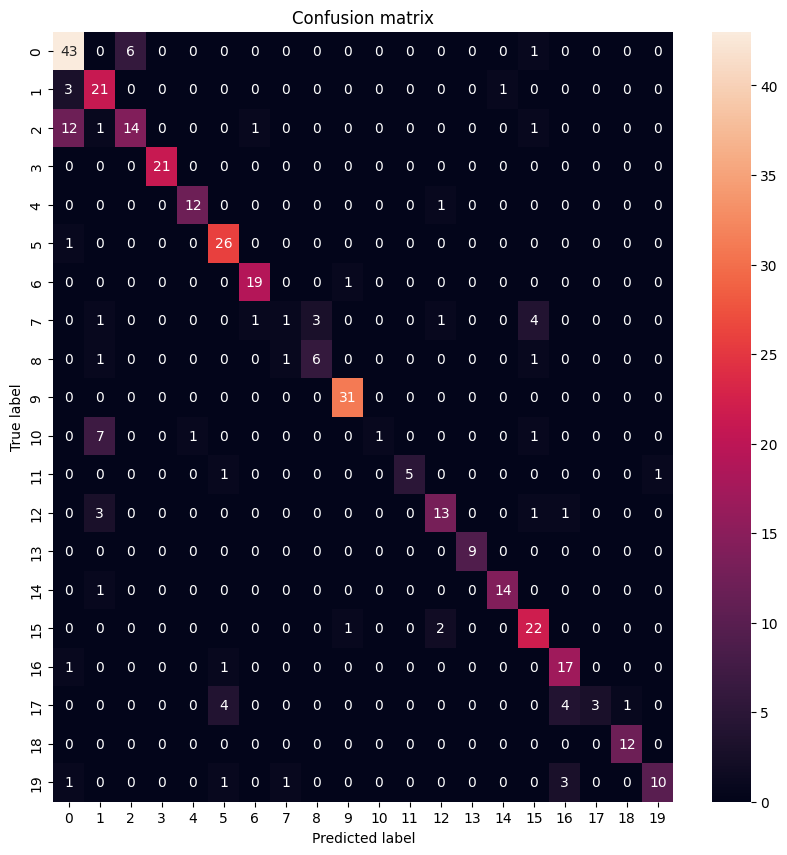

,Current Position Requirements,Current Position,Alternative 1,Alternative 2
0,University degree in Accounting or Finance; Kn...,Chief Accountant,Accountant,Project Manager
1,Higher education; Relevant work experience; K...,Office Manager,Administrative Assistant,Sales Manager
2,At least 2 years of work experience in the fie...,Web Developer,PHP Developer,Java Developer
3,Education in Accounting/Finance; Work experien...,Accountant,Chief Accountant,Lawyer
4,University degree in Jurisprudence. Experience...,Lawyer,Accountant,Administrative Assistant
...,...,...,...,...
374,Higher medical education; Basic knowledge of m...,Medical Representative,Administrative Assistant,Sales Manager
375,Higher education; Ability to perform organizat...,Marketing Specialist,Sales Manager,Project Manager
376,Experience in designing and delivering complex...,Project Manager,Software Developer,Web Developer
377,Higher education in Finance/ Economics; At lea...,Chief Accountant,Accountant,Administrative Assistant


In [11]:
preds_data = {'Current Position Requirements': [], 'Current Position': [], 'Alternative 1': [], 'Alternative 2': []}
y_preds_proba = logistic.predict_proba(X_test)

counter = 0 
for idx, (pred_row, true_job_position) in enumerate(zip(y_preds_proba, y_test)):
    class_preds = np.argsort(pred_row)
    # delete true class
    for i in [-1, -2]:
        if class_preds[i] == true_job_position:
            class_preds=np.delete(class_preds,i)
    # getting other 2 highest job predictions         
    top_classes = class_preds[-2:]
    # obtaining class name string from int label 
    class_names = enc.inverse_transform(top_classes)
    true_job_position_name = enc.inverse_transform([true_job_position])
    # saving to dict
    preds_data['Current Position Requirements'].append(X_test_words.iloc[idx])
    preds_data['Current Position'].append(true_job_position_name[0])
    preds_data['Alternative 1'].append(class_names[1])
    preds_data['Alternative 2'].append(class_names[0])

    
    counter +=1

preds_df = pd.DataFrame.from_dict(preds_data)
preds_df.to_csv('Recommendations.csv', index=False)
preds_df

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

def make_prediction(text):
    text = [text]
    text = vectorizer.transform(text)
    text = text.toarray()
    pred = logistic.predict(text)
    return enc.inverse_transform(pred)[0]

#save model
import pickle
pickle.dump(logistic, open('itreq.pkl','wb'))

preds_df

In [10]:
print(make_prediction(''' 
Proven working experience in project management.
Excellent client-facing and internal communication skills.
Excellent written and verbal communication skills.
Solid organizational skills including attention to detail and multitasking skills.
Strong working knowledge of Microsoft Office.
'''))

Project Manager
